# Live Inference and Benchmark CT-scan Data with OpenVINO™

## Kidney Segmentation with PyTorch Lightning and OpenVINO™ - Part 4 

This tutorial is a part of a series on how to train, optimize, quantize and show live inference on a medical segmentation model. The goal is to accelerate inference on a kidney segmentation model. The [UNet](https://arxiv.org/abs/1505.04597) model is trained from scratch, and the data is from [Kits19](https://github.com/neheller/kits19).

This tutorial shows how to benchmark performance of the model and show live inference with async API and MULTI plugin in OpenVINO.

This notebook needs a quantized OpenVINO IR model and images from the [KiTS-19](https://github.com/neheller/kits19) dataset, converted to 2D images. (To learn how the model is quantized, see the [Convert and Quantize a UNet Model and Show Live Inference](110-ct-segmentation-quantize-nncf.ipynb) tutorial.)

This notebook provides a pre-trained model, trained for 20 epochs with the full KiTS-19 frames dataset, which has an F1 score on the validation set of 0.9. The training code is available in the [PyTorch MONAI Training](../110-ct-segmentation-quantize/pytorch-monai-training.ipynb) notebook. 

For demonstration purposes, this tutorial will download one converted CT scan to use for inference.

#### Table of contents:
- [Imports](#Imports)
- [Settings](#Settings)
- [Benchmark Model Performance](#Benchmark-Model-Performance)
- [Download and Prepare Data](#Download-and-Prepare-Data)
- [Show Live Inference](#Show-Live-Inference)
    - [Load Model and List of Image Files](#Load-Model-and-List-of-Image-Files)
    - [Prepare images](#Prepare-images)
    - [Specify device](#Specify-device)
    - [Setting callback function](#Setting-callback-function)
    - [Create asynchronous inference queue and perform it](#Create-asynchronous-inference-queue-and-perform-it)


In [1]:
%pip install -q "openvino>=2023.1.0" "monai>=0.9.1,<1.0.0" "nncf>=2.5.0"

## Imports
[back to top ⬆️](#Table-of-contents:)


In [2]:
import os
import sys
import zipfile
from pathlib import Path

import numpy as np
from monai.transforms import LoadImage
import openvino as ov

from custom_segmentation import SegmentationModel

sys.path.append("../utils")
from notebook_utils import download_file

## Settings
[back to top ⬆️](#Table-of-contents:)

To use the pre-trained models, set `IR_PATH` to `"pretrained_model/unet44.xml"` and `COMPRESSED_MODEL_PATH` to `"pretrained_model/quantized_unet44.xml"`. To use a model that you trained or optimized yourself, adjust the model paths.

In [3]:
# The directory that contains the IR model (xml and bin) files.
models_dir = Path('pretrained_model')

ir_model_url = 'https://storage.openvinotoolkit.org/repositories/openvino_notebooks/models/kidney-segmentation-kits19/FP16-INT8/'
ir_model_name_xml = 'quantized_unet_kits19.xml'
ir_model_name_bin = 'quantized_unet_kits19.bin'

download_file(ir_model_url + ir_model_name_xml, filename=ir_model_name_xml, directory=models_dir)
download_file(ir_model_url + ir_model_name_bin, filename=ir_model_name_bin, directory=models_dir)

MODEL_PATH = models_dir / ir_model_name_xml

# Uncomment the next line to use the FP16 model instead of the quantized model.
# MODEL_PATH = "pretrained_model/unet_kits19.xml"

pretrained_model/quantized_unet_kits19.xml:   0%|          | 0.00/280k [00:00<?, ?B/s]

pretrained_model/quantized_unet_kits19.bin:   0%|          | 0.00/1.90M [00:00<?, ?B/s]

## Benchmark Model Performance
[back to top ⬆️](#Table-of-contents:)
To measure the inference performance of the IR model, use [Benchmark Tool](https://docs.openvino.ai/2023.3/openvino_sample_benchmark_tool.html) - an inference performance measurement tool in OpenVINO. Benchmark tool is a command-line application that can be run in the notebook with `! benchmark_app` or `%sx benchmark_app` commands.

> **Note**: The `benchmark_app` tool is able to measure the performance of the OpenVINO Intermediate Representation (OpenVINO IR) models only. For more accurate performance, run `benchmark_app` in a terminal/command prompt after closing other applications. Run `benchmark_app -m model.xml -d CPU` to benchmark async inference on CPU for one minute. Change `CPU` to `GPU` to benchmark on GPU. Run `benchmark_app --help` to see an overview of all command-line options.

In [4]:
core = ov.Core()
# By default, benchmark on MULTI:CPU,GPU if a GPU is available, otherwise on CPU.
device_list = ["MULTI:CPU,GPU" if "GPU" in core.available_devices else "AUTO"]

import ipywidgets as widgets

device = widgets.Dropdown(
    options=core.available_devices + device_list,
    value=device_list[0],
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'MULTI:CPU,GPU'), value='MULTI:CPU,GPU')

In [5]:
# Benchmark model
! benchmark_app -m $MODEL_PATH -d $device.value -t 15 -api sync

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2023.0.0-10926-b4452d56304-releases/2023/0
[ INFO ] 
[ INFO ] Device info:
[ INFO ] CPU
[ INFO ] Build ................................. 2023.0.0-10926-b4452d56304-releases/2023/0
[ INFO ] GPU
[ INFO ] Build ................................. 2023.0.0-10926-b4452d56304-releases/2023/0
[ INFO ] MULTI
[ INFO ] Build ................................. 2023.0.0-10926-b4452d56304-releases/2023/0
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(MULTI) performance hint will be set to PerformanceMode.LATENCY.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 15.75 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     input.1 (node: input.1) : f32 / [...] / 

## Download and Prepare Data
[back to top ⬆️](#Table-of-contents:)

Download one validation video for live inference. 

This tutorial reuses the `KitsDataset` class that was also used in the training and quantization notebook that will be released later.

The data is expected in `BASEDIR`. The `BASEDIR` directory should contain the `case_00000` to `case_00299` subdirectories. If the data for the case specified above does not already exist, it will be downloaded and extracted in the next cell.

In [6]:
# Directory that contains the CT scan data. This directory should contain subdirectories
# case_00XXX where XXX is between 000 and 299.
BASEDIR = Path("kits19_frames_1")
# The CT scan case number. For example: 16 for data from the case_00016 directory.
# Currently only 117 is supported.
CASE = 117

case_path = BASEDIR / f"case_{CASE:05d}"

if not case_path.exists():
    filename = download_file(
        f"https://storage.openvinotoolkit.org/data/test_data/openvino_notebooks/kits19/case_{CASE:05d}.zip"
    )
    with zipfile.ZipFile(filename, "r") as zip_ref:
        zip_ref.extractall(path=BASEDIR)
    os.remove(filename)  # remove zipfile
    print(f"Downloaded and extracted data for case_{CASE:05d}")
else:
    print(f"Data for case_{CASE:05d} exists")

Data for case_00117 exists


## Show Live Inference
[back to top ⬆️](#Table-of-contents:)

To show live inference on the model in the notebook, use the asynchronous processing feature of OpenVINO Runtime.

If you use a GPU device, with `device="GPU"` or `device="MULTI:CPU,GPU"` to do inference on an integrated graphics card, model loading will be slow the first time you run this code. The model will be cached, so after the first time model loading will be faster. For more information on OpenVINO Runtime, including Model Caching, refer to the [OpenVINO API tutorial](../002-openvino-api/002-openvino-api.ipynb).

We will use [`AsyncInferQueue`](https://docs.openvino.ai/2023.3/openvino_docs_OV_UG_Python_API_exclusives.html#asyncinferqueue) to perform asynchronous inference. It can be instantiated with compiled model and a number of jobs - parallel execution threads. If you don't pass a number of jobs or pass `0`, then OpenVINO will pick the optimal number based on your device and heuristics. After acquiring the inference queue, there are two jobs to do:

- Preprocess the data and push it to the inference queue. The preprocessing steps will remain the same.
- Tell the inference queue what to do with the model output after the inference is finished. It is represented by the `callback` python function that takes an inference result and data that we passed to the inference queue along with the prepared input data

Everything else will be handled by the `AsyncInferQueue` instance.

### Load Model and List of Image Files
[back to top ⬆️](#Table-of-contents:)

Load the segmentation model to OpenVINO Runtime with `SegmentationModel`, based on the Model API from [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo/). This model implementation includes pre and post processing for the model. For `SegmentationModel` this includes the code to create an overlay of the segmentation mask on the original image/frame. Uncomment the next cell to see the implementation.


In [7]:
core = ov.Core()
segmentation_model = SegmentationModel(
    ie=core, model_path=Path(MODEL_PATH), sigmoid=True, rotate_and_flip=True
)
image_paths = sorted(case_path.glob("imaging_frames/*jpg"))

print(f"{case_path.name}, {len(image_paths)} images")

case_00117, 69 images


### Prepare images
[back to top ⬆️](#Table-of-contents:)

Use the `reader = LoadImage()` function to read the images in the same way as in the [training](../110-ct-segmentation-quantize/pytorch-monai-training.ipynb) tutorial.

In [8]:
framebuf = []

next_frame_id = 0
reader = LoadImage(image_only=True, dtype=np.uint8)

while next_frame_id < len(image_paths) - 1:
    image_path = image_paths[next_frame_id]
    image = reader(str(image_path))
    framebuf.append(image)
    next_frame_id += 1

### Specify device
[back to top ⬆️](#Table-of-contents:)


In [9]:
device

Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'MULTI:CPU,GPU'), value='MULTI:CPU,GPU')

### Setting callback function
[back to top ⬆️](#Table-of-contents:)

When `callback` is set, any job that ends the inference, calls the Python function. The `callback` function must have two arguments: one is the request that calls the `callback`, which provides the `InferRequest` API; the other is called `userdata`, which provides the possibility of passing runtime values.

The `callback` function will show the results of inference.

In [10]:
import cv2
import copy
from IPython import display

from typing import Dict, Any

# Define a callback function that runs every time the asynchronous pipeline completes inference on a frame
def completion_callback(infer_request: ov.InferRequest, user_data: Dict[str, Any],) -> None:
    preprocess_meta = user_data['preprocess_meta']
    
    raw_outputs = {out.any_name: copy.deepcopy(res.data) for out, res in zip(infer_request.model_outputs, infer_request.output_tensors)}
    frame = segmentation_model.postprocess(raw_outputs, preprocess_meta)

    _, encoded_img = cv2.imencode(".jpg", frame, params=[cv2.IMWRITE_JPEG_QUALITY, 90])
    # Create IPython image
    i = display.Image(data=encoded_img)

    # Display the image in this notebook
    display.clear_output(wait=True)
    display.display(i)

### Create asynchronous inference queue and perform it
[back to top ⬆️](#Table-of-contents:)


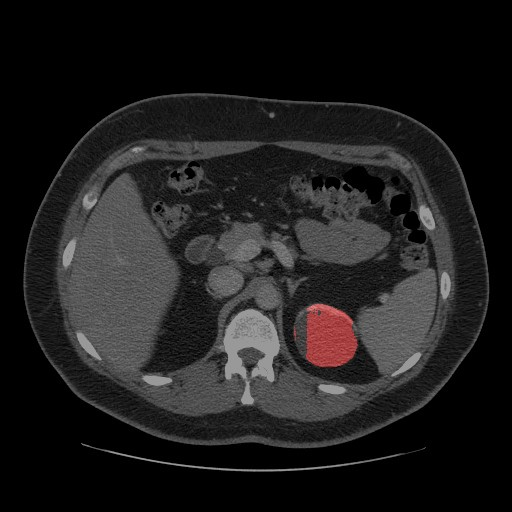

Loaded model to Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'MULTI:CPU,GPU'), value='MULTI:CPU,GPU') in 1.05 seconds.
Total time to infer all frames: 1.881s
Time per frame: 0.027659s (36.155 FPS)


In [11]:
import time

load_start_time = time.perf_counter()
compiled_model = core.compile_model(segmentation_model.net, device.value)
# Create asynchronous inference queue with optimal number of infer requests
infer_queue = ov.AsyncInferQueue(compiled_model)
infer_queue.set_callback(completion_callback)
load_end_time = time.perf_counter()

results = [None] * len(framebuf)
frame_number = 0

# Perform inference on every frame in the framebuffer
start_time = time.time()
for i, input_frame in enumerate(framebuf):
    inputs, preprocessing_meta = segmentation_model.preprocess({segmentation_model.net.input(0): input_frame})
    infer_queue.start_async(inputs, {'preprocess_meta': preprocessing_meta})

# Wait until all inference requests in the AsyncInferQueue are completed
infer_queue.wait_all()
stop_time = time.time()

# Calculate total inference time and FPS
total_time = stop_time - start_time
fps = len(framebuf) / total_time
time_per_frame = 1 / fps 

print(f"Loaded model to {device} in {load_end_time-load_start_time:.2f} seconds.")

print(f'Total time to infer all frames: {total_time:.3f}s')
print(f'Time per frame: {time_per_frame:.6f}s ({fps:.3f} FPS)')